Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# path for desktop PC
sys.path.append(r'C:\Users\test\Masterarbeit')
# path for surface PC
#sys.path.append(r'C:\Users\Surface\Masterarbeit')

%matplotlib inline
# path for desktop PC
path = r"C:\Users\test\Masterarbeit\data\WZ_2_Feature_Engineered_Fynn6.xlsx"
# path for surface PC
#path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)

Transformation Pipeline

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# print the shapes of the data
print(data_num.shape, X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
# print(pd.DataFrame(X_train, columns=feature_names).describe())

Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 37) torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])


Class for a customizable NN

In [10]:
# create a class for Neural Network with a custom architecture
class Custom_NN_Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, do_rate):
        """
        Neural Network model with a custom architecture.
        @param input_dim:   number of input features
        @param hidden_dims: list of integers representing the number of neurons in each hidden layer e.g. [64, 128, 64, 32]
        @param output_dim:  number of output features (usually 1 for regression tasks)
        @param do_rate:     dropout rate for regularization
               
        """
        super(Custom_NN_Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.do_rate = do_rate
        
        # create the layers of the model
        self.layers = torch.nn.ModuleList()
        last_dim = input_dim
        for dim in hidden_dims:
            self.layers.append(torch.nn.Linear(last_dim, dim))
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Dropout(do_rate))
            last_dim = dim
        
        # output layer
        self.layers.append(torch.nn.Linear(last_dim, output_dim))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Training function for NN including data loader with batch sampling, early stopping

In [11]:
# training functions for the model, optimizer Adam, loss function MSELoss, data loader for batching the data, early stopping
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=128, n_epochs=1000, lr=0.01, weight_decay=0.0001, patience=20):
        
    """
        Function for training neural Network.
        @param model            The neural network model to be trained.
        @param X_train_tensor   The matrix of features for the training data.
        @param y_train_tensor   The vector of target values for the training data.
        @param X_val_tensor     The matrix of features for the validation data.
        @param y_val_tensor     The vector of target values for the validation data.
        @param batch_size       The size of the batches for training.
        @param n_epochs         The number of epochs for training.
        @param lr               The learning rate for the optimizer.
        @param weight_decay     The weight decay for the optimizer.
        @param patience         The number of epochs with no improvement after which training will be stopped.
                
        @return model          The trained neural network model.
    """
    
    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define Mean Squared Error loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')
    
    # Adam optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # Early Stopping values
    best_val_loss = np.inf
    epochs_no_improve = 0
    loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        model.train()                           # Set model to training mode
        batch_losses = []
        for X_batch, y_batch in train_loader:   # loop over all batches in the DataLoader
            X_batch.to(device)                  # Move data to the device (GPU or CPU)
            y_batch.to(device)
            optimizer.zero_grad()               # Reset gradients
            y_pred = model(X_batch)             # Forward pass
            loss = loss_fn(y_pred, y_batch)     # Compute MSE loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights
            batch_losses.append(loss.item())   
        loss_history.append(loss.item())    # Save loss value

        # calculate validation loss
        model.eval()                            # Set model to evaluation mode
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)           # Forward pass on validation set
            val_loss = loss_fn(y_val_pred, y_val_tensor)  # Compute MSE loss on validation set
            val_loss_history.append(val_loss.item())
            
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                model.load_state_dict(best_model_state)
                break     
           
    # plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label='Train Loss', color='tab:blue')
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE Loss')
    # plt.title('Training Loss over Epochs')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    
    return model

Hyperparameter Search with Optuna for network architecture

https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py#L93

https://www.youtube.com/watch?v=P6NwZVl8ttc


In [14]:
import optuna

def objective(trial):
 
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 4)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 32, 256, step=32)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256]) 
    
    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    decay = 0.5
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = torch.nn.functional.mse_loss(y_val_pred, y_val_tensor).item()
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return val_loss


Execute Optuna Study

In [15]:
from optuna.trial import TrialState

# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-10 16:33:25,593] A new study created in memory with name: no-name-07bc177b-4e01-42d4-8a7c-08bf13bfeff0


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden dimensions: [224, 112, 56]


Best trial: 0. Best value: 9.76357:   1%|          | 1/100 [04:27<7:21:22, 267.50s/it]

Early stopping at epoch 192, Best Val Loss: 9.5110
[I 2025-07-10 16:37:53,082] Trial 0 finished with value: 9.763571739196777 and parameters: {'n_layer': 3, 'n_neurons': 224, 'do_rate': 0.3327435232208362, 'lr': 0.003107840481541976, 'batch_size': 64}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 0. Best value: 9.76357:   2%|▏         | 2/100 [05:05<3:36:13, 132.38s/it]

Early stopping at epoch 62, Best Val Loss: 46.1953
[I 2025-07-10 16:38:30,897] Trial 1 finished with value: 49.21614074707031 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.08927887046260813, 'lr': 0.00020352781146411206, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [32, 16, 8, 4]


Best trial: 0. Best value: 9.76357:   3%|▎         | 3/100 [08:51<4:43:25, 175.31s/it]

Early stopping at epoch 401, Best Val Loss: 478.6981
[I 2025-07-10 16:42:17,283] Trial 2 finished with value: 482.8465576171875 and parameters: {'n_layer': 4, 'n_neurons': 32, 'do_rate': 0.34773843797821874, 'lr': 0.0002913179991663791, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [256, 128]


Best trial: 0. Best value: 9.76357:   4%|▍         | 4/100 [09:26<3:11:28, 119.68s/it]

Early stopping at epoch 71, Best Val Loss: 17.4485
[I 2025-07-10 16:42:51,679] Trial 3 finished with value: 18.04728126525879 and parameters: {'n_layer': 2, 'n_neurons': 256, 'do_rate': 0.4101368508982036, 'lr': 0.0013561628558827383, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [192, 96]


Best trial: 0. Best value: 9.76357:   5%|▌         | 5/100 [11:54<3:26:08, 130.19s/it]

Early stopping at epoch 306, Best Val Loss: 9.6458
[I 2025-07-10 16:45:20,514] Trial 4 finished with value: 10.16660213470459 and parameters: {'n_layer': 2, 'n_neurons': 192, 'do_rate': 0.3544231448753933, 'lr': 0.006341584681459852, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [96, 48, 24]


Best trial: 0. Best value: 9.76357:   6%|▌         | 6/100 [13:48<3:15:18, 124.67s/it]

Early stopping at epoch 211, Best Val Loss: 10.5737
[I 2025-07-10 16:47:14,461] Trial 5 finished with value: 12.513741493225098 and parameters: {'n_layer': 3, 'n_neurons': 96, 'do_rate': 0.22622303307348984, 'lr': 0.0027090803404824448, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 0. Best value: 9.76357:   7%|▋         | 7/100 [15:17<2:55:02, 112.93s/it]

Early stopping at epoch 151, Best Val Loss: 114.1525
[I 2025-07-10 16:48:43,225] Trial 6 finished with value: 132.5817108154297 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.466698892815624, 'lr': 0.0007105291480501569, 'batch_size': 256}. Best is trial 0 with value: 9.763571739196777.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 7. Best value: 8.9071:   8%|▊         | 8/100 [21:10<4:50:18, 189.33s/it] 

Early stopping at epoch 219, Best Val Loss: 8.6576
[I 2025-07-10 16:54:36,143] Trial 7 finished with value: 8.90710163116455 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.05490107256731739, 'lr': 0.002553577656282978, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [192, 96, 48]


Best trial: 7. Best value: 8.9071:   9%|▉         | 9/100 [21:39<3:31:16, 139.30s/it]

Early stopping at epoch 53, Best Val Loss: 15.8001
[I 2025-07-10 16:55:05,431] Trial 8 finished with value: 25.344898223876953 and parameters: {'n_layer': 3, 'n_neurons': 192, 'do_rate': 0.109755013743656, 'lr': 0.0052813978454280056, 'batch_size': 256}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [224, 112, 56, 28]


Best trial: 7. Best value: 8.9071:  10%|█         | 10/100 [22:00<2:34:01, 102.68s/it]

Early stopping at epoch 36, Best Val Loss: 100.2928
[I 2025-07-10 16:55:26,114] Trial 9 finished with value: 192.6368865966797 and parameters: {'n_layer': 4, 'n_neurons': 224, 'do_rate': 0.4610450571701648, 'lr': 0.00031498737006358587, 'batch_size': 256}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 7. Best value: 8.9071:  11%|█         | 11/100 [24:28<2:52:56, 116.59s/it]

Early stopping at epoch 93, Best Val Loss: 11.9939
[I 2025-07-10 16:57:54,244] Trial 10 finished with value: 12.99985408782959 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.19807249797403736, 'lr': 0.0011105160342403662, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [160, 80, 40]


Best trial: 7. Best value: 8.9071:  12%|█▏        | 12/100 [29:08<4:04:00, 166.36s/it]

Early stopping at epoch 199, Best Val Loss: 9.4029
[I 2025-07-10 17:02:34,462] Trial 11 finished with value: 9.66580867767334 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.2770530217010935, 'lr': 0.003066361158224765, 'batch_size': 64}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [128, 64, 32]


Best trial: 7. Best value: 8.9071:  13%|█▎        | 13/100 [30:46<3:31:01, 145.54s/it]

Early stopping at epoch 118, Best Val Loss: 10.3932
[I 2025-07-10 17:04:12,067] Trial 12 finished with value: 10.93112850189209 and parameters: {'n_layer': 3, 'n_neurons': 128, 'do_rate': 0.21103930228360068, 'lr': 0.00912980565392161, 'batch_size': 128}. Best is trial 7 with value: 8.90710163116455.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  14%|█▍        | 14/100 [36:30<4:54:40, 205.59s/it]

Early stopping at epoch 241, Best Val Loss: 8.4186
[I 2025-07-10 17:09:56,413] Trial 13 finished with value: 8.483834266662598 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.14218218501306715, 'lr': 0.0024602309060651768, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48]


Best trial: 13. Best value: 8.48383:  15%|█▌        | 15/100 [37:59<4:01:12, 170.26s/it]

[I 2025-07-10 17:11:24,817] Trial 14 pruned. 
Hidden dimensions: [32, 16, 8]


Best trial: 13. Best value: 8.48383:  16%|█▌        | 16/100 [38:09<2:50:50, 122.03s/it]

[I 2025-07-10 17:11:34,825] Trial 15 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  17%|█▋        | 17/100 [38:46<2:13:42, 96.65s/it] 

Early stopping at epoch 46, Best Val Loss: 16.9650
[I 2025-07-10 17:12:12,473] Trial 16 finished with value: 23.580141067504883 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.16118799032287226, 'lr': 0.0019053076511329223, 'batch_size': 128}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  18%|█▊        | 18/100 [42:16<2:58:40, 130.74s/it]

Early stopping at epoch 131, Best Val Loss: 9.1516
[I 2025-07-10 17:15:42,570] Trial 17 finished with value: 9.698763847351074 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06154433127010737, 'lr': 0.00465811489175491, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32]


Best trial: 13. Best value: 8.48383:  19%|█▉        | 19/100 [43:03<2:22:16, 105.39s/it]

[I 2025-07-10 17:16:28,897] Trial 18 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  20%|██        | 20/100 [43:21<1:45:29, 79.12s/it] 

[I 2025-07-10 17:16:46,796] Trial 19 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  21%|██        | 21/100 [44:13<1:33:27, 70.98s/it]

[I 2025-07-10 17:17:38,780] Trial 20 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  22%|██▏       | 22/100 [44:23<1:08:36, 52.78s/it]

[I 2025-07-10 17:17:49,129] Trial 21 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  23%|██▎       | 23/100 [44:32<50:41, 39.50s/it]  

[I 2025-07-10 17:17:57,663] Trial 22 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  24%|██▍       | 24/100 [46:04<1:10:09, 55.39s/it]

[I 2025-07-10 17:19:30,107] Trial 23 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  25%|██▌       | 25/100 [46:13<51:40, 41.35s/it]  

[I 2025-07-10 17:19:38,698] Trial 24 pruned. 
Hidden dimensions: [224, 112]


Best trial: 13. Best value: 8.48383:  26%|██▌       | 26/100 [48:19<1:22:23, 66.81s/it]

[I 2025-07-10 17:21:44,919] Trial 25 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  27%|██▋       | 27/100 [48:28<1:00:23, 49.63s/it]

[I 2025-07-10 17:21:54,477] Trial 26 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  28%|██▊       | 28/100 [48:58<52:15, 43.54s/it]  

Early stopping at epoch 36, Best Val Loss: 18.3194
[I 2025-07-10 17:22:23,806] Trial 27 finished with value: 21.194677352905273 and parameters: {'n_layer': 3, 'n_neurons': 96, 'do_rate': 0.1253892187632321, 'lr': 0.0016296165312043647, 'batch_size': 128}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  29%|██▉       | 29/100 [50:35<1:10:28, 59.56s/it]

Early stopping at epoch 70, Best Val Loss: 11.3686
[I 2025-07-10 17:24:00,740] Trial 28 finished with value: 11.718938827514648 and parameters: {'n_layer': 3, 'n_neurons': 160, 'do_rate': 0.08253556373277164, 'lr': 0.006683338165653631, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [256, 128, 64]


Best trial: 13. Best value: 8.48383:  30%|███       | 30/100 [50:44<52:04, 44.64s/it]  

[I 2025-07-10 17:24:10,554] Trial 29 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  31%|███       | 31/100 [50:56<39:45, 34.57s/it]

[I 2025-07-10 17:24:21,635] Trial 30 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  32%|███▏      | 32/100 [54:31<1:40:34, 88.75s/it]

Early stopping at epoch 134, Best Val Loss: 9.1395
[I 2025-07-10 17:27:56,799] Trial 31 finished with value: 9.260013580322266 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.050503253361037365, 'lr': 0.004780762922525119, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  33%|███▎      | 33/100 [54:40<1:12:33, 64.97s/it]

[I 2025-07-10 17:28:06,286] Trial 32 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  34%|███▍      | 34/100 [54:50<53:08, 48.30s/it]  

[I 2025-07-10 17:28:15,707] Trial 33 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  35%|███▌      | 35/100 [54:59<39:41, 36.64s/it]

[I 2025-07-10 17:28:25,146] Trial 34 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  36%|███▌      | 36/100 [55:07<30:00, 28.14s/it]

[I 2025-07-10 17:28:33,438] Trial 35 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  37%|███▋      | 37/100 [56:23<44:24, 42.29s/it]

[I 2025-07-10 17:29:48,762] Trial 36 pruned. 
Hidden dimensions: [32, 16]


Best trial: 13. Best value: 8.48383:  38%|███▊      | 38/100 [56:27<31:59, 30.96s/it]

[I 2025-07-10 17:29:53,252] Trial 37 pruned. 
Hidden dimensions: [224, 112, 56, 28]


Best trial: 13. Best value: 8.48383:  39%|███▉      | 39/100 [56:37<25:04, 24.66s/it]

[I 2025-07-10 17:30:03,239] Trial 38 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  40%|████      | 40/100 [57:06<25:52, 25.87s/it]

[I 2025-07-10 17:30:31,942] Trial 39 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  41%|████      | 41/100 [57:16<20:47, 21.14s/it]

[I 2025-07-10 17:30:42,024] Trial 40 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  42%|████▏     | 42/100 [57:25<17:03, 17.64s/it]

[I 2025-07-10 17:30:51,511] Trial 41 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  43%|████▎     | 43/100 [1:01:23<1:19:22, 83.55s/it]

Early stopping at epoch 146, Best Val Loss: 9.3943
[I 2025-07-10 17:34:48,860] Trial 42 finished with value: 9.837752342224121 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.08149970361182311, 'lr': 0.0042470341539591824, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  44%|████▍     | 44/100 [1:01:34<57:47, 61.92s/it]  

[I 2025-07-10 17:35:00,297] Trial 43 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  45%|████▌     | 45/100 [1:01:38<40:41, 44.39s/it]

[I 2025-07-10 17:35:03,776] Trial 44 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  46%|████▌     | 46/100 [1:06:57<1:54:05, 126.77s/it]

Early stopping at epoch 201, Best Val Loss: 8.7000
[I 2025-07-10 17:40:22,770] Trial 45 finished with value: 8.953618049621582 and parameters: {'n_layer': 4, 'n_neurons': 160, 'do_rate': 0.0694206534652986, 'lr': 0.0020206154910399443, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  47%|████▋     | 47/100 [1:07:08<1:21:21, 92.10s/it] 

[I 2025-07-10 17:40:33,991] Trial 46 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  48%|████▊     | 48/100 [1:07:18<58:23, 67.37s/it]  

[I 2025-07-10 17:40:43,628] Trial 47 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  49%|████▉     | 49/100 [1:07:21<41:01, 48.26s/it]

[I 2025-07-10 17:40:47,300] Trial 48 pruned. 
Hidden dimensions: [192, 96, 48]


Best trial: 13. Best value: 8.48383:  50%|█████     | 50/100 [1:08:04<38:49, 46.59s/it]

[I 2025-07-10 17:41:30,009] Trial 49 pruned. 
Hidden dimensions: [160, 80]


Best trial: 13. Best value: 8.48383:  51%|█████     | 51/100 [1:08:50<37:50, 46.34s/it]

[I 2025-07-10 17:42:15,751] Trial 50 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  52%|█████▏    | 52/100 [1:12:05<1:12:52, 91.10s/it]

Early stopping at epoch 122, Best Val Loss: 9.4624
[I 2025-07-10 17:45:31,290] Trial 51 finished with value: 10.10460090637207 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.09815936466198952, 'lr': 0.0038083593207017684, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  53%|█████▎    | 53/100 [1:16:06<1:46:33, 136.04s/it]

Early stopping at epoch 150, Best Val Loss: 9.1356
[I 2025-07-10 17:49:32,177] Trial 52 finished with value: 9.4656400680542 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.05257561064224124, 'lr': 0.005543905980551906, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  54%|█████▍    | 54/100 [1:16:16<1:15:12, 98.09s/it] 

[I 2025-07-10 17:49:41,744] Trial 53 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  55%|█████▌    | 55/100 [1:16:28<54:21, 72.48s/it]  

[I 2025-07-10 17:49:54,477] Trial 54 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  56%|█████▌    | 56/100 [1:17:23<49:10, 67.06s/it]

[I 2025-07-10 17:50:48,892] Trial 55 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  57%|█████▋    | 57/100 [1:18:23<46:40, 65.12s/it]

[I 2025-07-10 17:51:49,471] Trial 56 pruned. 
Hidden dimensions: [160, 80, 40]


Best trial: 13. Best value: 8.48383:  58%|█████▊    | 58/100 [1:18:32<33:41, 48.14s/it]

[I 2025-07-10 17:51:57,974] Trial 57 pruned. 
Hidden dimensions: [64, 32, 16]


Best trial: 13. Best value: 8.48383:  59%|█████▉    | 59/100 [1:18:58<28:26, 41.62s/it]

[I 2025-07-10 17:52:24,375] Trial 58 pruned. 
Hidden dimensions: [192, 96, 48, 24]


Best trial: 13. Best value: 8.48383:  60%|██████    | 60/100 [1:19:05<20:50, 31.26s/it]

[I 2025-07-10 17:52:31,472] Trial 59 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  61%|██████    | 61/100 [1:19:18<16:42, 25.71s/it]

[I 2025-07-10 17:52:44,237] Trial 60 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  62%|██████▏   | 62/100 [1:23:58<1:04:31, 101.89s/it]

Early stopping at epoch 176, Best Val Loss: 9.0261
[I 2025-07-10 17:57:23,898] Trial 61 finished with value: 9.318634033203125 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.07005801650537088, 'lr': 0.00430370482777337, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  63%|██████▎   | 63/100 [1:27:39<1:24:58, 137.80s/it]

Early stopping at epoch 139, Best Val Loss: 9.1893
[I 2025-07-10 18:01:05,492] Trial 62 finished with value: 9.911477088928223 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.07323540331731229, 'lr': 0.00393165820907292, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  64%|██████▍   | 64/100 [1:27:49<59:35, 99.32s/it]   

[I 2025-07-10 18:01:15,006] Trial 63 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  65%|██████▌   | 65/100 [1:27:58<42:13, 72.39s/it]

[I 2025-07-10 18:01:24,558] Trial 64 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  66%|██████▌   | 66/100 [1:28:16<31:38, 55.85s/it]

[I 2025-07-10 18:01:41,807] Trial 65 pruned. 
Hidden dimensions: [96, 48, 24]


Best trial: 13. Best value: 8.48383:  67%|██████▋   | 67/100 [1:29:03<29:15, 53.19s/it]

[I 2025-07-10 18:02:28,797] Trial 66 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  68%|██████▊   | 68/100 [1:29:12<21:23, 40.09s/it]

[I 2025-07-10 18:02:38,338] Trial 67 pruned. 
Hidden dimensions: [128, 64, 32]


Best trial: 13. Best value: 8.48383:  69%|██████▉   | 69/100 [1:30:47<29:08, 56.40s/it]

[I 2025-07-10 18:04:12,770] Trial 68 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  70%|███████   | 70/100 [1:32:36<36:11, 72.38s/it]

Early stopping at epoch 68, Best Val Loss: 11.7325
[I 2025-07-10 18:06:02,451] Trial 69 finished with value: 12.36947250366211 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.11895347985435008, 'lr': 0.007801920975954875, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  71%|███████   | 71/100 [1:32:43<25:24, 52.58s/it]

[I 2025-07-10 18:06:08,809] Trial 70 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  72%|███████▏  | 72/100 [1:37:29<57:13, 122.64s/it]

Early stopping at epoch 180, Best Val Loss: 8.7526
[I 2025-07-10 18:10:54,926] Trial 71 finished with value: 9.098934173583984 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06241669797220716, 'lr': 0.004561207834048388, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  73%|███████▎  | 73/100 [1:37:38<39:54, 88.70s/it] 

[I 2025-07-10 18:11:04,443] Trial 72 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  74%|███████▍  | 74/100 [1:42:44<1:06:39, 153.84s/it]

Early stopping at epoch 193, Best Val Loss: 8.6606
[I 2025-07-10 18:16:10,271] Trial 73 finished with value: 8.736711502075195 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.06315319580676537, 'lr': 0.0034755303617822015, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  75%|███████▌  | 75/100 [1:46:13<1:10:55, 170.23s/it]

[I 2025-07-10 18:19:38,745] Trial 74 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  76%|███████▌  | 76/100 [1:49:12<1:09:10, 172.94s/it]

[I 2025-07-10 18:22:38,007] Trial 75 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  77%|███████▋  | 77/100 [1:51:31<1:02:26, 162.91s/it]

Early stopping at epoch 88, Best Val Loss: 10.1344
[I 2025-07-10 18:24:57,520] Trial 76 finished with value: 10.99487590789795 and parameters: {'n_layer': 4, 'n_neurons': 64, 'do_rate': 0.08144935984628726, 'lr': 0.00551847867897167, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  78%|███████▊  | 78/100 [1:56:24<1:13:59, 201.81s/it]

Early stopping at epoch 184, Best Val Loss: 8.6859
[I 2025-07-10 18:29:50,083] Trial 77 finished with value: 8.730438232421875 and parameters: {'n_layer': 4, 'n_neurons': 96, 'do_rate': 0.050314710669982325, 'lr': 0.004634951104385174, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  79%|███████▉  | 79/100 [1:56:45<51:36, 147.47s/it]  

[I 2025-07-10 18:30:10,759] Trial 78 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  80%|████████  | 80/100 [1:56:48<34:45, 104.28s/it]

[I 2025-07-10 18:30:14,262] Trial 79 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  81%|████████  | 81/100 [1:56:58<24:00, 75.84s/it] 

[I 2025-07-10 18:30:23,745] Trial 80 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  82%|████████▏ | 82/100 [1:57:07<16:46, 55.92s/it]

[I 2025-07-10 18:30:33,197] Trial 81 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  83%|████████▎ | 83/100 [1:57:17<11:53, 41.99s/it]

[I 2025-07-10 18:30:42,678] Trial 82 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  84%|████████▍ | 84/100 [1:57:28<08:43, 32.72s/it]

[I 2025-07-10 18:30:53,778] Trial 83 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  85%|████████▌ | 85/100 [2:01:41<24:44, 98.97s/it]

Early stopping at epoch 160, Best Val Loss: 9.1826
[I 2025-07-10 18:35:07,330] Trial 84 finished with value: 9.624985694885254 and parameters: {'n_layer': 4, 'n_neurons': 128, 'do_rate': 0.07623397749878878, 'lr': 0.004175683467875643, 'batch_size': 64}. Best is trial 13 with value: 8.483834266662598.
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  86%|████████▌ | 86/100 [2:01:51<16:49, 72.14s/it]

[I 2025-07-10 18:35:16,870] Trial 85 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  87%|████████▋ | 87/100 [2:02:32<13:38, 62.96s/it]

[I 2025-07-10 18:35:58,403] Trial 86 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383:  88%|████████▊ | 88/100 [2:02:42<09:22, 46.91s/it]

[I 2025-07-10 18:36:07,852] Trial 87 pruned. 
Hidden dimensions: [32, 16, 8, 4]


Best trial: 13. Best value: 8.48383:  89%|████████▉ | 89/100 [2:02:51<06:32, 35.68s/it]

[I 2025-07-10 18:36:17,352] Trial 88 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  90%|█████████ | 90/100 [2:03:01<04:38, 27.87s/it]

[I 2025-07-10 18:36:27,002] Trial 89 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  91%|█████████ | 91/100 [2:03:06<03:10, 21.16s/it]

[I 2025-07-10 18:36:32,504] Trial 90 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  92%|█████████▏| 92/100 [2:03:16<02:21, 17.68s/it]

[I 2025-07-10 18:36:42,069] Trial 91 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  93%|█████████▎| 93/100 [2:03:26<01:46, 15.24s/it]

[I 2025-07-10 18:36:51,598] Trial 92 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  94%|█████████▍| 94/100 [2:03:37<01:24, 14.02s/it]

[I 2025-07-10 18:37:02,784] Trial 93 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  95%|█████████▌| 95/100 [2:03:48<01:05, 13.18s/it]

[I 2025-07-10 18:37:14,018] Trial 94 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  96%|█████████▌| 96/100 [2:06:21<03:40, 55.25s/it]

[I 2025-07-10 18:39:47,411] Trial 95 pruned. 
Hidden dimensions: [160, 80, 40, 20]


Best trial: 13. Best value: 8.48383:  97%|█████████▋| 97/100 [2:06:42<02:14, 44.88s/it]

[I 2025-07-10 18:40:08,098] Trial 96 pruned. 
Hidden dimensions: [128, 64, 32, 16]


Best trial: 13. Best value: 8.48383:  98%|█████████▊| 98/100 [2:06:46<01:05, 32.54s/it]

[I 2025-07-10 18:40:11,849] Trial 97 pruned. 
Hidden dimensions: [96, 48, 24, 12]


Best trial: 13. Best value: 8.48383:  99%|█████████▉| 99/100 [2:06:55<00:25, 25.65s/it]

[I 2025-07-10 18:40:21,412] Trial 98 pruned. 
Hidden dimensions: [64, 32, 16, 8]


Best trial: 13. Best value: 8.48383: 100%|██████████| 100/100 [2:07:32<00:00, 76.52s/it]

[I 2025-07-10 18:40:57,711] Trial 99 pruned. 
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  69
  Number of complete trials:  31
Best trial:
  Value:  8.483834266662598
  Params: 
    n_layer: 3
    n_neurons: 160
    do_rate: 0.14218218501306715
    lr: 0.0024602309060651768
    batch_size: 64


In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
# Create model instance with best parameters and move to device
model1 = Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[128, 64, 16], output_dim=1, do_rate=0.27).to(device)  # Create model instance and move to device
# Train the model with the best parameters
# Note: The parameters here are just an example, you can use the best parameters from the
tr_model = train_model(model1, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, batch_size=64, n_epochs=1000, lr=0.002, weight_decay=0.0001, patience=20)

Using device: cuda
Epoch 1/1000, Train Loss: 2037.5430, Val Loss: 95.0155, Best Val Loss: 95.0155
Epoch 3/1000, Train Loss: 963.2272, Val Loss: 56.2146, Best Val Loss: 56.2146
Epoch 9/1000, Train Loss: 860.3916, Val Loss: 46.6540, Best Val Loss: 46.6540
Epoch 16/1000, Train Loss: 744.8759, Val Loss: 39.7929, Best Val Loss: 39.7929
Epoch 21/1000, Train Loss: 667.9785, Val Loss: 33.3344, Best Val Loss: 33.3344
Epoch 30/1000, Train Loss: 488.7540, Val Loss: 32.6325, Best Val Loss: 32.6325
Epoch 35/1000, Train Loss: 446.1650, Val Loss: 29.6237, Best Val Loss: 29.6237
Epoch 42/1000, Train Loss: 341.2702, Val Loss: 23.5828, Best Val Loss: 23.5828
Epoch 50/1000, Train Loss: 241.2570, Val Loss: 17.2428, Best Val Loss: 17.2428
Epoch 58/1000, Train Loss: 175.8921, Val Loss: 15.1599, Best Val Loss: 15.1599
Epoch 61/1000, Train Loss: 146.9154, Val Loss: 15.1244, Best Val Loss: 15.1244
Epoch 63/1000, Train Loss: 142.1354, Val Loss: 14.6447, Best Val Loss: 14.6447
Epoch 71/1000, Train Loss: 110.0712

Inference on the Train and test data without aleatoric uncertainty

In [11]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model.train()
tr_model.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred = torch.stack([tr_model(X_tr) for i in range(n_samples)]).detach().cpu().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred = torch.stack([tr_model(X_te) for i in range(n_samples)]).detach().cpu().numpy()

Plot the uncertainty interval for the NN with MC Dropout

R² on Train Data: 0.827
R² on Test Data: 0.813


C:\Users\test\AppData\Local\Temp\ipykernel_14916\224388241.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred)**2,0) -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))


Negative Log Likelihood (NLL) on Test Data: -2.636
Number of true values within the confidence interval: 8312 out of 10403
Coverage: 79.90%


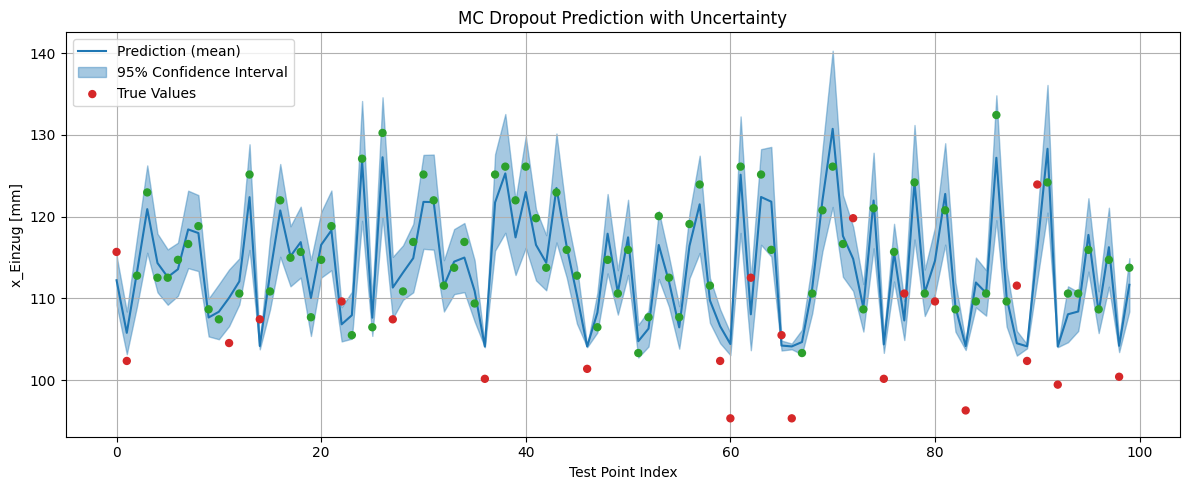

In [ ]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)
# Adjust standard deviation for uncertainty estimation
#y_test_pred_std = y_test_pred_std + (1/tau)

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Optuna Hyperparameter Search for legthscale and tau

In [ ]:
def objective(trial):

    # number of stochastic forward passes for MC Dropout
    n_samples = 250  

    # fixed hyperparameters for simplicity
    hidden_dims = [128, 64, 16]  #! Use fixed hidden dimensions for simplicity
    lr = 0.002  #! learning rate
    batch_size = 64  #! batch size
 
    # hyperparameter for sampling with Optuna
    tau = trial.suggest_float("tau", 0.01, 1.0, log=True)   #! range ok?
    lengthscale = trial.suggest_float("lengthscale", 0.01, 1.0, log=True) #! range ok?
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate adjust range according to first run 

    N = X_train_tensor.shape[0]  # number of training samples
    # weight decay 
    weight_decay = lengthscale**2 * (1 - do_rate) / (2 * N * tau)  # Adjusted weight decay according to paper

    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims= hidden_dims,
        output_dim=1,
        do_rate=do_rate
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = torch.nn.functional.mse_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.train()  # Set model to training mode for MC Dropout predcition
        with torch.no_grad():
            y_val_preds = torch.stack(
                [model(X_val_tensor) for _ in range(n_samples)]
            )

            mc_val_pred_mean = y_val_preds.mean(axis=0)
            mc_val_pred_std = y_val_preds.std(axis=0)

            # compute the negative log liklihood
            ll_val_loss = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_val_preds)**2, 0) - np.log(n_samples)
                            - 0.5 * np.log(2 * np.pi) - 0.5 * np.log(tau))
            nll_val_loss = - ll_val_loss.mean()

            
        trial.report(nll_val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    
    return nll_val_loss


In [ ]:
#! handling the train data
# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)

# Calculate R² score on the train data
r2_train = r2_score(y_train, y_train_pred_mean)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)
# Adjust standard deviation for uncertainty estimation
#y_test_pred_std = y_test_pred_std + (1/tau)

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), y_test_pred_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# calculate NLL for the test data
ll = (torch.logsumexp(-0.5 * tau * (y_test_tensor.cpu()[None] - y_test_pred)**2,0) -np.log(n_samples) - 0.5 * np.log(2*np.pi) + 0.5 * np.log(tau))
test_ll = ll.mean()  # Mean Negative Log Likelihood
test_ll = test_ll.to('cpu')  # Move to CPU for printing
nll = -test_ll
print(f"Negative Log Likelihood (NLL) on Test Data: {test_ll:.3f}")


# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean+ 2 * mc_std

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[6873 5130 6255 ...  402 3043 1975]
[ 65.      81.7435  83.9345 ... 127.3499 127.3499 127.3499]
Lowest of mc_lower_bound_full: 89.7096
Highest of mc_upper_bound_full: 141.4293
Highest difference between mc_lower_bound_full and mc_upper_bound_full: 25.7839
Index of highest difference: 3941


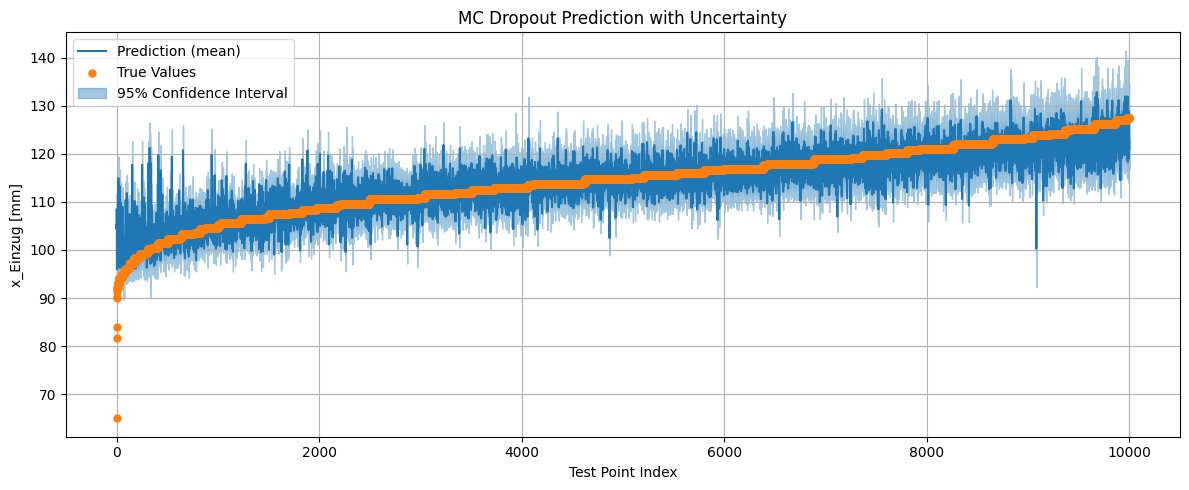

In [64]:
sort_idx = np.argsort(y_test_tensor.cpu().flatten().numpy())
print(sort_idx)
# Sort the predictions and standard deviations for the first 1000 points    
mc_mean_sorted = mc_mean[sort_idx]
mc_std_sorted = mc_std[sort_idx]
y_test_sorted = y_test_tensor.cpu().flatten().numpy()[sort_idx]

n = 10000

mc_mean_sorted = mc_mean_sorted[:n]
mc_std_sorted = mc_std_sorted[:n]   
y_test_sorted = y_test_sorted[:n]

print(y_test_sorted)

mc_lower_bound_full = mc_mean_sorted - 2 * mc_std_sorted
mc_upper_bound_full = mc_mean_sorted + 2 * mc_std_sorted
# print lower of mc_lower_bound_full and highest of mc_upper_bound_full
print(f"Lowest of mc_lower_bound_full: {mc_lower_bound_full.min():.4f}")
print(f"Highest of mc_upper_bound_full: {mc_upper_bound_full.max():.4f}")

#print the highes difference between mc_lower_bound_full and mc_upper_bound_full and the index of the highest difference
diff = mc_upper_bound_full - mc_lower_bound_full
print(f"Highest difference between mc_lower_bound_full and mc_upper_bound_full: {diff.max():.4f}")
print(f"Index of highest difference: {np.argmax(diff)}")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)  # Create an index axis for plotting
# Plot the predicted mean
plt.plot(mc_mean_sorted, label="Prediction (mean)", color='tab:blue')

# plot true values for the first 100 points
plt.scatter(x_axis, y_test_sorted, label="True Values", c='tab:orange', s=25, zorder=3)

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound_full, mc_upper_bound_full, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')
# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Old Code

In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
    

# DataLoader for batching the data
batch_size = 64  # Define batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Define a fully connected neural network with ReLU activations and Dropout
dp = 0.27  # Dropout probability set to 5%

# model = torch.nn.Sequential(
#     torch.nn.Linear(37, 64),     # Input layer -> 64 neurons
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
#     torch.nn.Linear(64, 128),   # Hidden layer -> 128 neurons
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
#     torch.nn.Linear(128, 64),   # Hidden layer -> 64 neurons
#     torch.nn.ReLU(),
#     torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
#     torch.nn.Linear(64, 1)      # Output layer -> 1 value (regression)
# ).to(device)  # Move model to device (GPU or CPU)

model = Cusom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[128, 64], output_dim=1, do_rate=dp).to(device)  # Create model instance and move to device

# Define Mean Squared Error loss function
loss_fn = torch.nn.MSELoss(reduction='mean')
# Set learning rate and optimizer
lr = 0.002
weight_decay = 0.0001  # Weight decay for regularization

# Adam optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)  

# Early Stopping Parameter
patience = 20
best_val_loss = np.inf
epochs_no_improve = 0
n_epochs = 1000
loss_history = []
val_loss_history = []

for epoch in range(n_epochs):
    model.train()                           # Set model to training mode
    batch_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()               # Reset gradients
        y_pred = model(X_batch)             # Forward pass
        loss = loss_fn(y_pred, y_batch)     # Compute MSE loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update weights
        batch_losses.append(loss.item())   
    loss_history.append(loss.item())    # Save loss value

    # calculate validation loss
    model.eval()                            # Set model to evaluation mode
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)           # Forward pass on validation set
        val_loss = loss_fn(y_val_pred, y_val_tensor)  # Compute MSE loss on validation set
        val_loss_history.append(val_loss.item())
        
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
        
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
        
    # Update plot every 100 epochs
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Train Loss', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#print(loss_history)